<div class="alert alert-warning">
    
<b>Disclaimer:</b> 
    
The main objective of the <i>Jupyter</i> notebooks is to show how to use the models of the <i>QENS library</i> by
    
- building a fitting model: composition of models, convolution with a resolution function  
- setting and running the fit  
- extracting and displaying information about the results  

These steps have a minimizer-dependent syntax. That is one of the reasons why different minimizers have been used in the notebooks provided as examples.  
But, the initial guessed parameters might not be optimal, resulting in a poor fit of the reference data.

</div>

# Lorentzian with lmfit 

## Introduction

<div class="alert alert-info">
    
The objective of this notebook is to show how to use one of the models of 
the <a href="https://github.com/QENSlibrary/QENSmodels">QENSlibrary</a>, <b>lorentzian</b>, to perform some fits. 

<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html">scipy.optimize.curve_fit</a> is used for fitting.
</div>

### Physical units

For information about unit conversion, please refer to the jupyter notebook called `Convert_units.ipynb` in the `tools` folder.

The dictionary of units defined in the cell below specify the units of the refined parameters adapted to the convention used in the experimental datafile.

In [1]:
# Units of parameters for selected QENS model and experimental data
dict_physical_units = {"omega": "1/ps", 
                       'scale': "unit_of_signal.ps", 
                       'center': "1/ps", 
                       'hwhm': "1/ps"}

## Importing libraries

In [2]:
# import python modules for plotting, fitting
from __future__ import print_function
import numpy as np

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# for interactivity (plots, buttons...)
import ipywidgets

# import model from QENS library
import QENSmodels

## Plot of the fitting model

The widget below shows the lorentzian peak shape function imported from QENSmodels where the function's parameters *Scale*, *Center* and *FWHM* can be varied.

In [3]:
# Dictionary of initial values
ini_parameters = {'scale': 5., 'center': 5., 'hwhm': 3.}

def interactive_fct(scale, center, hwhm):
    xs = np.linspace(-10, 10, 100)
    
    fig1, ax1 = plt.subplots()
    ax1.plot(xs, QENSmodels.lorentzian(xs, scale, center, hwhm))
    ax1.set_xlabel('x')
    ax1.grid()

# Define sliders for modifiable parameters and their range of variations
scale_slider = ipywidgets.FloatSlider(value=ini_parameters['scale'],
                                      min=0.1, max=10, step=0.1,
                                      description='scale',
                                      continuous_update=False) 

center_slider = ipywidgets.IntSlider(value=ini_parameters['center'],
                                     min=-10, max=10, step=1,
                                     description='center', 
                                     continuous_update=False) 

hwhm_slider = ipywidgets.FloatSlider(value=ini_parameters['hwhm'],
                                        min=0.1, max=10, step=0.1,
                                        description='hwhm', 
                                        continuous_update=False)

grid_sliders = ipywidgets.HBox([ipywidgets.VBox([scale_slider, center_slider])
                                ,ipywidgets.VBox([hwhm_slider])])
                             
# Define function to reset all parameters' values to the initial ones
def reset_values(b):
    """Reset the interactive plots to inital values."""
    scale_slider.value = ini_parameters['scale'] 
    center_slider.value = ini_parameters['center']  
    hwhm_slider.value = ini_parameters['hwhm']

# Define reset button and occurring action when clicking on it
reset_button = ipywidgets.Button(description = "Reset")
reset_button.on_click(reset_values)

# Display the interactive plot
interactive_plot = ipywidgets.interactive_output(interactive_fct,       
                                         {'scale': scale_slider,
                                          'center': center_slider,
                                          'hwhm': hwhm_slider})  
                                            
display(grid_sliders, interactive_plot, reset_button)

Output()

Button(description='Reset', style=ButtonStyle())

## Creating reference data

**Input:** the reference data for this simple example correspond to a Lorentzian with added noise.

The fit is performed using `scipy.optimize.curve_fit`. <br> The example is based on implementations from https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

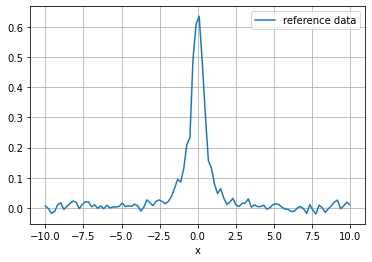

In [4]:
# Creation of reference data
nb_points = 100
xx = np.linspace(-10, 10, nb_points)
added_noise = np.random.normal(0, 1, nb_points)
lorentzian_noisy = QENSmodels.lorentzian(xx, scale=0.89, center=-0.025, hwhm=0.45)*(1. + 0.1*added_noise) + 0.01*added_noise

fig0, ax0 = plt.subplots()
ax0.plot(xx, lorentzian_noisy, label='reference data')
ax0.set_xlabel('x')
ax0.grid()
ax0.legend();

## Setting and fitting

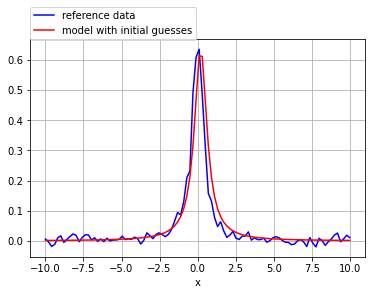

In [5]:
# From https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
# perform fit with initial guesses scale=1, center=0.2 HWHM=0.5
initial_parameters_values = [1, 0.2, 0.5]

fig1, ax1 = plt.subplots()
ax1.plot(xx, lorentzian_noisy, 'b-', label='reference data')
ax1.plot(xx, QENSmodels.lorentzian(xx, *initial_parameters_values), 'r-', label='model with initial guesses')
ax1.set_xlabel('x')
ax1.legend(bbox_to_anchor=(0., 1.15), loc='upper left', borderaxespad=0.)
ax1.grid();

In [6]:
popt, pcov = curve_fit(QENSmodels.lorentzian, xx, lorentzian_noisy, p0=initial_parameters_values)

## Plotting the results

In [7]:
# Calculation of the errors on the refined parameters:
perr = np.sqrt(np.diag(pcov))

print('Values of refined parameters:')
print('scale:', popt[0],'+/-', perr[0], dict_physical_units['scale'])
print('center :', popt[1],'+/-', perr[1], dict_physical_units['center'])
print('HWHM', popt[2],'+/-', perr[2], dict_physical_units['hwhm'])

Values of refined parameters:
scale: 0.9292828887916907 +/- 0.014819749115384164 unit_of_signal.ps
center : 0.009699290835895564 +/- 0.0070537957514746645 1/ps
HWHM 0.4429742289504747 +/- 0.00999933383287716 1/ps


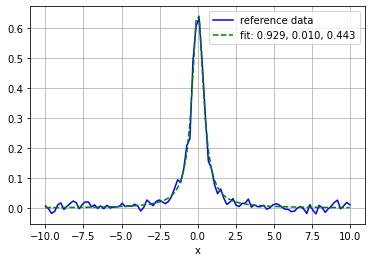

In [8]:
 # Comparison of reference data with fitting result
fig2, ax2 = plt.subplots()
ax2.plot(xx, lorentzian_noisy, 'b-', label='reference data')
ax2.plot(xx, QENSmodels.lorentzian(xx, *popt), 'g--', label='fit: %5.3f, %5.3f, %5.3f' % tuple(popt))
ax2.legend()
ax2.set_xlabel('x')
ax2.grid();